$num clusters = k$<br>
$weights = \alpha \in (0,\inf)^{N}$<br>
$samples = \mathcal{D} \in \mathcal{R}^{N, d}$<br>
$optimal \ workload = L = \dfrac{\sum{\alpha}}{k}$<br>
$cluster \ workload = A = \sum_{\alpha \in c_i}{\alpha_i}$<br><br>

$cluster(x_i, \alpha_i) = argmin_j \mathcal{L}(x_i, \alpha_i,c_j)$<br>
$\mathcal{L}(x_i, \alpha_i, c_j) = \left\lVert x_i - c_j \right\rVert + \alpha_i(1 + \lambda)^{A - L + \alpha_i}$<br><br>
$\lambda = e^{\dfrac{log(\bar{\alpha}) - log(L)}{\bar{\alpha} - L}} - 1$

In [ ]:
#(3/4) * (np.exp(np.log(alphabar/self.optimal_workload)/(alphabar - self.optimal_workload)) - 1)

In [1]:
import numpy as np
import seaborn
import importlib
import pandas as pd
from sklearn.cluster import KMeans
seaborn.set(color_codes=True)
seaborn.set(style="ticks")
import matplotlib.pyplot as plt

In [2]:
import alpha_kmeans
alpha_kmeans = importlib.reload(alpha_kmeans)

def graph_clusters(labels, weights, data):
    map_ = {0:'A',1:'B',2:'C',3:'D', 4 : 'E'}
    labels = [map_[idx] for idx in labels]
    return seaborn.scatterplot(x = data[:,0], y = data[:,1], 
                        size = np.squeeze(weights), 
                        hue = labels,
                        legend = False)

N = 80
data = np.random.rand(N,2)
weights = np.random.randint(1,20,(N,1)) * 1/20

cluster = alpha_kmeans.AlphaKmeans(5)
a_cluster_labels, metrics = cluster.fit(data, weights, metrics = True)
cluster.get_max_cost(data, weights)

Initializing centers ...
Optimizing
Iteration: 11
Stable configuration reached.
Complete


8.933234748361917

{'cluster_distance': (2.8401568473810683, 2.143112096046572, 1.852200456876995, 2.8648854981155085), 'cluster_weight': (8.250000000000002, 6.6, 7.500000000000001, 7.85), 'cluster_total': (11.09015684738107, 8.743112096046572, 9.352200456876997, 10.714885498115509)}
11.09015684738107


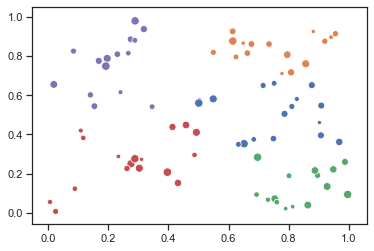

In [3]:
#graph_clusters(labels, weights, data)
def sk_cluster_get_max_cost(distances, weights, labels):
    return max(alpha_kmeans.AlphaKmeans.static_get_cluster_metrics(distances, weights, labels)['cluster_total'])

sk_cluster = KMeans(5, n_init = 1).fit(data)
labels, distances = sk_cluster.predict(data), sk_cluster.transform(data)
print(alpha_kmeans.AlphaKmeans.static_get_cluster_metrics(distances, weights, labels))
print(sk_cluster_get_max_cost(distances, weights, labels))

graph_clusters(labels, weights, data)

# 1. Prove difference between this and kmeans

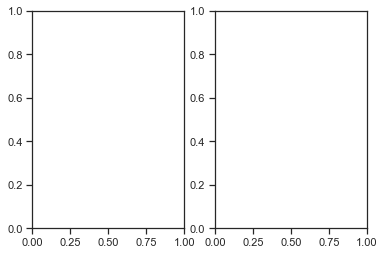

In [15]:
fig, ax = plt.subplots(1,2)

In [16]:
# for unbiased test
data = np.random.randn(N,2)
scale_alphas = np.random.rand(N)

In [ ]:
# for biased alpha test
data = np.random.randn(N,2)
scale_alphas = np.log(np.exp(data[:,0] + data[:,1]))**2
epsilon = 0.0001
scale_alphas = (scale_alphas - scale_alphas.min() + epsilon)/(scale_alphas.max() - scale_alphas.min())

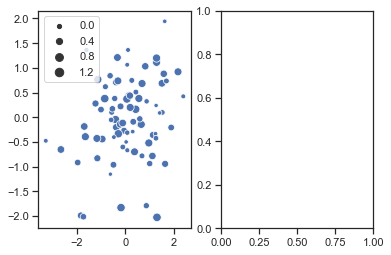

In [17]:
seaborn.scatterplot(x = data[:,0], y = data[:,1], size = scale_alphas, ax = ax[0])
#seaborn.distplot(scale_alphas)
fig

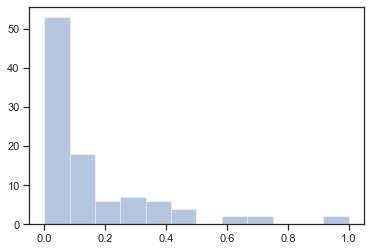

In [114]:
seaborn.distplot(scale_alphas, kde = False)

In [115]:
scale_alphas.min(), scale_alphas.max()

(7.362099851779176e-06, 1.0000073620998517)

C:\Users\allen\clustering\alpha_kmeans.py:41: RuntimeWarning: Mean of empty slice.
  self.centers[k] = substituents.mean(axis = 0)
C:\Users\allen\Anaconda3\envs\analysis_env\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\allen\clustering\alpha_kmeans.py:28: RuntimeWarning: overflow encountered in power
  alphamod = alphai * (1 + self.lambd)**(self.alpha_costs - self.optimal_workload + alphai)


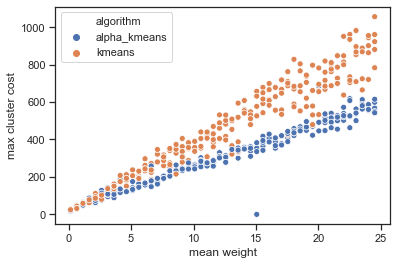

In [118]:
def append_row(df, row):
    df.loc[-1] = row  # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()

#sampling hyperparameters
n_tests = 50
max_mean = 25
max_mult = max_mean/scale_alphas.mean()

#increment = 0.01
increment = (max_mult - 1)/n_tests
#max_exp = np.log10(max_weight/increment)
reps = 5

#cluster hyperparameters
N = 100
k = 5

results_df = pd.DataFrame(columns = ['algorithm','mean weight','max cluster cost'])
for i in range(0, n_tests):
    #weight_multiplier = increment * 10**(max_exp * i/n_tests)
    weight_multiplier = 1 + (increment * i)
    alphas = weight_multiplier * scale_alphas
    mean_weight = np.mean(alphas)
    for j in range(reps):
        #alpha_kmeans
        alpha_clusters = alpha_kmeans.AlphaKmeans(k)
        labels = alpha_clusters.fit(data, alphas, verbose = False)
        max_cost = alpha_clusters.get_max_cost(data, alphas)
        append_row(results_df, ['alpha_kmeans', mean_weight, max_cost])
        #kmeans
        sk_cluster = KMeans(5, n_init = 1).fit(data)
        labels, distances = sk_cluster.predict(data), sk_cluster.transform(data)
        max_cost = sk_cluster_get_max_cost(distances, alphas, labels)
        append_row(results_df, ['kmeans', mean_weight, max_cost])
        
seaborn.scatterplot(data = results_df, x = 'mean weight', y = 'max cluster cost', hue = 'algorithm')

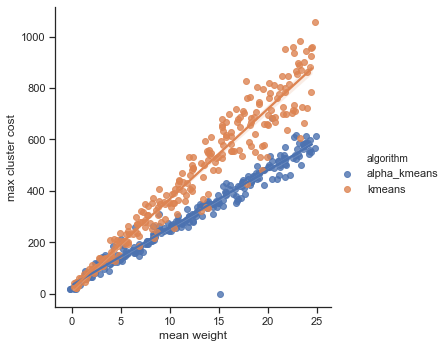

In [119]:
fig = seaborn.lmplot(data = results_df, x = 'mean weight', 
                    y = 'max cluster cost', 
                    hue = 'algorithm', x_jitter = 0.4, ax = ax[1])
fig.savefig("alpha_vs_kmeans_biased.png")

# Show difference in clustering

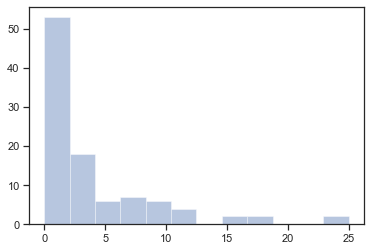

In [131]:
alphas = scale_alphas * 25
seaborn.distplot(alphas, kde = False)

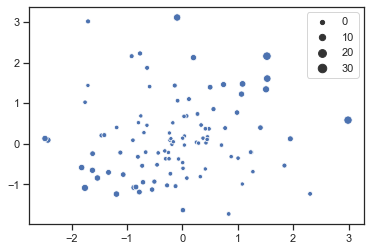

In [132]:
seaborn.scatterplot(x=  data[:,0], y = data[:,1], size = alphas)

In [135]:
alpha_clusters = alpha_kmeans.AlphaKmeans(k)
alpha_labels = alpha_clusters.fit(data, alphas, verbose = False)
alpha_cost = alpha_clusters.get_max_cost(data, alphas)

sk_cluster = KMeans(5, n_init = 1).fit(data)
labels, distances = sk_cluster.predict(data), sk_cluster.transform(data)
max_cost = sk_cluster_get_max_cost(distances, alphas, labels)

alpha_df = pd.DataFrame({'x' : data[:,0], 'y' : data[:,1], 'weight' : alphas.reshape(-1),
                         'label':alpha_labels, 'algo' : 'Alpha Kmeans'})

kmeans_df = pd.DataFrame({'x' : data[:,0], 'y' : data[:,1], 'weight' : alphas.reshape(-1),
                         'label':labels, 'algo' : 'Niave Kmeans'})

combined_df = alpha_df.append(kmeans_df)
print('alpha_max_cost:', alpha_cost, '\n', 'kmeans_max_cost: ', max_cost)

alpha_max_cost: 107.8961177978809 
 kmeans_max_cost:  144.28838597926176


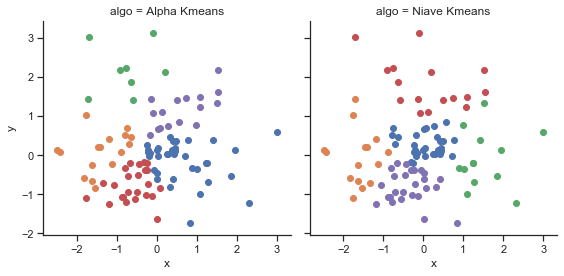

In [140]:
g = seaborn.FacetGrid(combined_df, col="algo", hue = "label", 
                      margin_titles=True, height=4)
g.map(plt.scatter, "x", "y")

g.savefig('cluster_comparison.png')

# Show lambda calculation

In [186]:
N = 100
k = 5
epsilon = 0.1
#np.random.seed(10)

X = np.random.rand(N, 2) * 7
alpha = np.maximum(1,(X[:,0])) * 20

a = alpha_kmeans.AlphaKmeans(k)
a._initialize(X, alpha)
optimal_lamb = a.lambd
print('Optimal Lambda: ', optimal_lamb)

Optimal Lambda:  0.001529330807289453


In [187]:
store = []
for i in np.maximum(0, np.array(optimal_lamb + 0.01 * np.arange(-10,100, 2))): 
    alpha_clusters = alpha_kmeans.AlphaKmeans(k)
    alpha_labels, metrics = alpha_clusters.fit(data, alphas, verbose = False, lambd = i, metrics = True)
    max_cluster_cost = max(metrics['cluster_total'])
    average_cluster_cost = np.mean(metrics['cluster_weight'])
    mean_dist = np.mean(metrics['cluster_distance'])
    store.append((i, max_cluster_cost, average_cluster_cost, mean_dist))

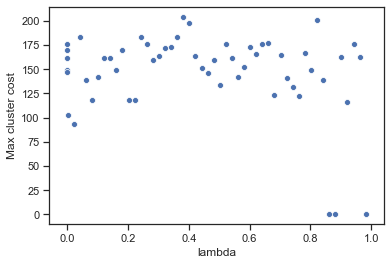

In [188]:
df = pd.DataFrame(store, columns = ['lambda','Max cluster cost','average cluster cost', 'Average distance cost'])

seaborn.scatterplot(data = df, x = 'lambda', y = 'Max cluster cost')